In [101]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import os
import json

# Extended professional palette
colors = {
    'Greedy_Worst': '#E6194B',  # Red
    'Edf': '#FF7F00',  # Orange
    'Greedy_Green': '#3CB44B',  # Green
    'MILP': '#4363D8',  # Blue
    'RR': '#911EB4',  # Purple
    'Sjf': '#FFD700',  # Gold
}

mode = ''
schedules_path = f'../schedules/{mode}/'
graphs_output = f'../graphing/graphs/{mode}/'
schedules = {
    'Edf': pd.read_csv(f'{schedules_path}edf_schedule.csv'),
    'Sjf': pd.read_csv(f'{schedules_path}sjf_schedule.csv'),
    'Greedy_Worst': pd.read_csv(f'{schedules_path}worst_schedule.csv'),
    'Greedy_Green': pd.read_csv(f'{schedules_path}green_schedule.csv'),
    'MILP': pd.read_csv(f'{schedules_path}milp_binary_schedule.csv'),
    'RR': pd.read_csv(f'{schedules_path}rr_schedule.csv'),
}

milp_schedule_df = schedules['MILP']
milp_schedule_df['route'] = milp_schedule_df['route_key']
associations_df = pd.read_csv('../data/associations_df.csv')
forecasts_df = pd.read_csv('../data/forecast_data.csv')

traceroute_path = '../config/traceroutes/pmeter_tr/'

with open('../config/jobs_config/4000_jobs.json', 'r') as f:
    job_data = json.load(f)


In [109]:
def process_pmeter_tr(pmeter_tr_path: str):
    """Process traceroute files in JSON Lines format with smart geolocation filling."""
    results = {}
    results_ips = {}
    for file in sorted(f for f in os.listdir(pmeter_tr_path) if f.endswith('.json')):
        file_path = os.path.join(pmeter_tr_path, file)
        print(file_path)
        with open(file_path, 'r') as f:
            line_number = 0
            for line in f:
                line_number += 1
                line = line.strip()

                trace = json.loads(line)

                if not isinstance(trace, dict):
                    continue

                # Get route info from metadata
                meta = trace.get('metadata', {})
                src = meta.get('source', 'unknown')
                dest = meta.get('destination', 'unknown')

                if not isinstance(trace.get('hops'), list):
                    continue

                hops = []
                previous_geo = None
                ips = []
                # First pass to collect future geolocations
                future_geos = []
                for hop in reversed(trace['hops']):
                    geo = hop.get('geo', {})
                    if geo.get('lat') is not None and geo.get('lon') is not None:
                        future_geos.append((geo['lat'], geo['lon']))
                    else:
                        future_geos.append(None)
                future_geos.reverse()

                for i, hop in enumerate(trace['hops']):
                    ip = hop.get('ip', 'unknown')
                    geo = hop.get('geo', {})
                    ttl = hop.get('ttl', 0)
                    rtt = hop.get('rtt_ms', 0) / 1000

                    # Get current or nearest valid geolocation
                    lat, lon = geo.get('lat'), geo.get('lon')
                    geo_source = "original"

                    if lat is None or lon is None:
                        if previous_geo:
                            lat, lon = previous_geo
                            geo_source = "prev_hop"
                        elif i < len(future_geos) - 1 and future_geos[i + 1]:
                            lat, lon = future_geos[i + 1]
                            geo_source = "next_hop"
                        else:
                            geo_source = "unknown"
                    else:
                        previous_geo = (lat, lon)
                    hops.append({
                        'ip': ip,
                        'lat': lat,
                        'lon': lon,
                        'ttl': ttl,
                        'rtt': rtt,
                        'node_id': src
                    })
                    ips.append(ip)

                key = f"{src}_{dest}"
                results[key] = hops
                results_ips[key] = ips

    return results, results_ips


traceroute_map, name_to_ips = process_pmeter_tr(traceroute_path)
print(traceroute_map)
for key, value in traceroute_map.items():
    print(f"Key:{key} len{len(value)}")

../config/traceroutes/pmeter_tr/chi_to_buff.json
../config/traceroutes/pmeter_tr/oregon_to_tacc_chi.json
../config/traceroutes/pmeter_tr/tacc_to_buff.json
{'chi_buff': [{'ip': '10.140.83.254', 'lat': 41.7821, 'lon': -87.6046, 'ttl': 1, 'rtt': 0.00020899999999999998, 'node_id': 'chi'}, {'ip': '192.5.86.1', 'lat': 41.7821, 'lon': -87.6046, 'ttl': 2, 'rtt': 0.001556, 'node_id': 'chi'}, {'ip': '192.5.170.238', 'lat': 41.7183, 'lon': -87.9789, 'ttl': 3, 'rtt': 0.002554, 'node_id': 'chi'}, {'ip': '64.57.20.0', 'lat': 41.4993, 'lon': -81.6944, 'ttl': 4, 'rtt': 0.005248, 'node_id': 'chi'}, {'ip': '163.253.2.20', 'lat': 42.3006, 'lon': -83.6914, 'ttl': 5, 'rtt': 0.004458, 'node_id': 'chi'}, {'ip': '163.253.1.217', 'lat': 41.4993, 'lon': -81.6944, 'ttl': 6, 'rtt': 0.003339, 'node_id': 'chi'}, {'ip': '64.57.20.54', 'lat': 41.4993, 'lon': -81.6944, 'ttl': 7, 'rtt': 0.002305, 'node_id': 'chi'}, {'ip': '66.109.0.108', 'lat': 41.8781, 'lon': -87.6298, 'ttl': 8, 'rtt': 0.002391, 'node_id': 'chi'}, {'i

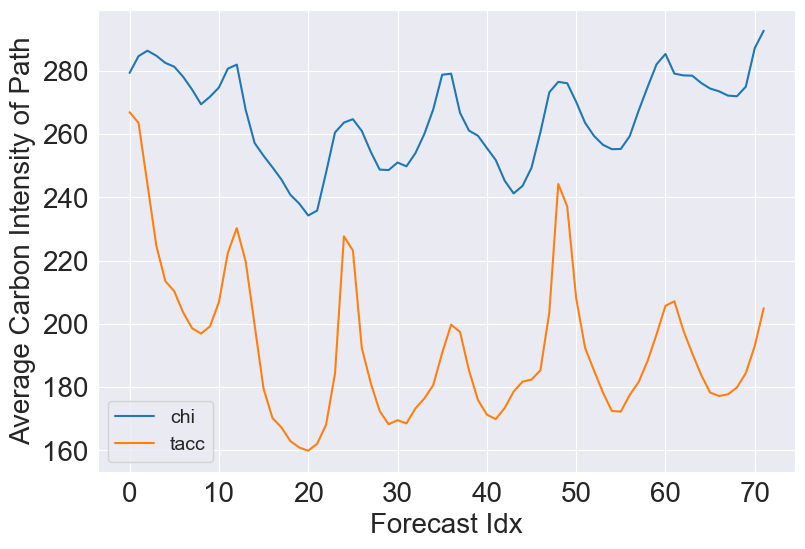

In [92]:
chi_traceroute = name_to_ips['chi_buff']
tacc_tr = name_to_ips['tacc_buff']

uc_mean_forecast = forecasts_df[forecasts_df['ip'].isin(chi_traceroute)].groupby('forecast_idx')['ci'].mean()
tacc_mean_forecast = forecasts_df[forecasts_df['ip'].isin(tacc_tr)].groupby('forecast_idx')['ci'].mean()

plt.figure(figsize=(9, 6))
plt.plot(uc_mean_forecast, label='chi')
plt.plot(tacc_mean_forecast, label='tacc')
plt.xlabel("Forecast Idx", fontsize=20)
plt.ylabel("Average Carbon Intensity of Path", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=14)
plt.savefig(f"{graphs_output}24hour_forecast_plot.pdf", format='pdf', dpi=800)
plt.show()


/var/folders/rn/lb6d61xx4_j9fhhnzl_6wkk40000gn/T/ipykernel_46885/698933564.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_data = job_df.groupby('deadline_bin')['bytes_gb'].mean().reset_index()


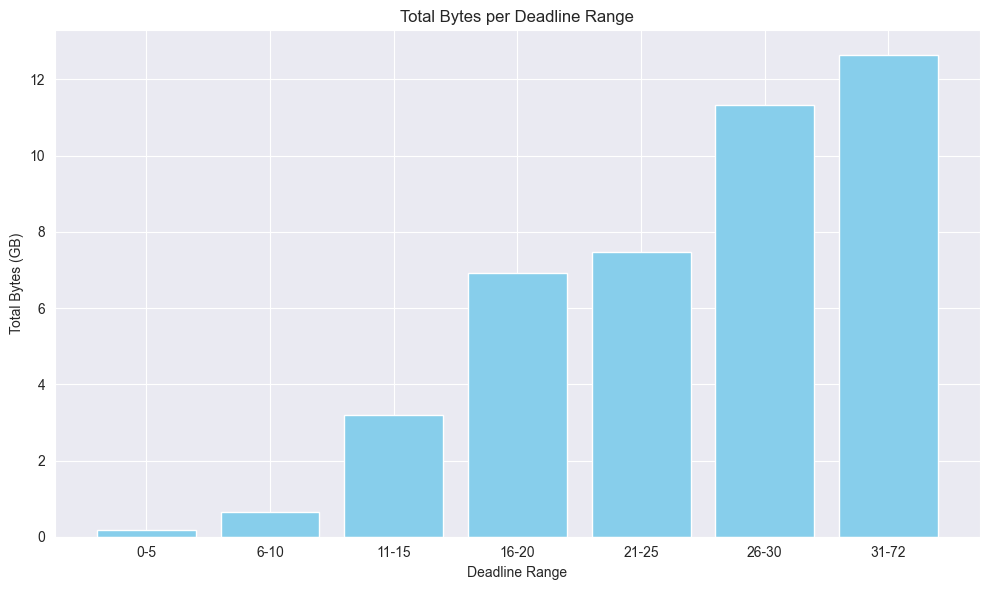

In [102]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# Convert data into DataFrame
job_df = pd.DataFrame(job_data)

# Convert bytes to GB for better visualization
job_df["bytes_gb"] = job_df["bytes"] / (1024 ** 3)  # Convert bytes to GB

# Create bins for deadlines
bins = [0, 5, 10, 15, 20, 25, 30, 72]  # Example bins for deadline ranges
labels = ['0-5', '6-10', '11-15', '16-20', '21-25', '26-30', '31-72']
job_df['deadline_bin'] = pd.cut(job_df['deadline'], bins=bins, labels=labels, right=False)

# Aggregate the total bytes (in GB) for each deadline bin
agg_data = job_df.groupby('deadline_bin')['bytes_gb'].mean().reset_index()

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Bar plot for bytes in GB (binned by deadline)
ax.bar(agg_data['deadline_bin'], agg_data['bytes_gb'], color='skyblue', label="Bytes (GB)")

# Adding labels
ax.set_xlabel("Deadline Range")
ax.set_ylabel("Total Bytes (GB)")
ax.set_title("Total Bytes per Deadline Range")

# Show plot
plt.tight_layout()
plt.savefig('job_bins.pdf', format='pdf', dpi=800)
plt.show()


31440426361840


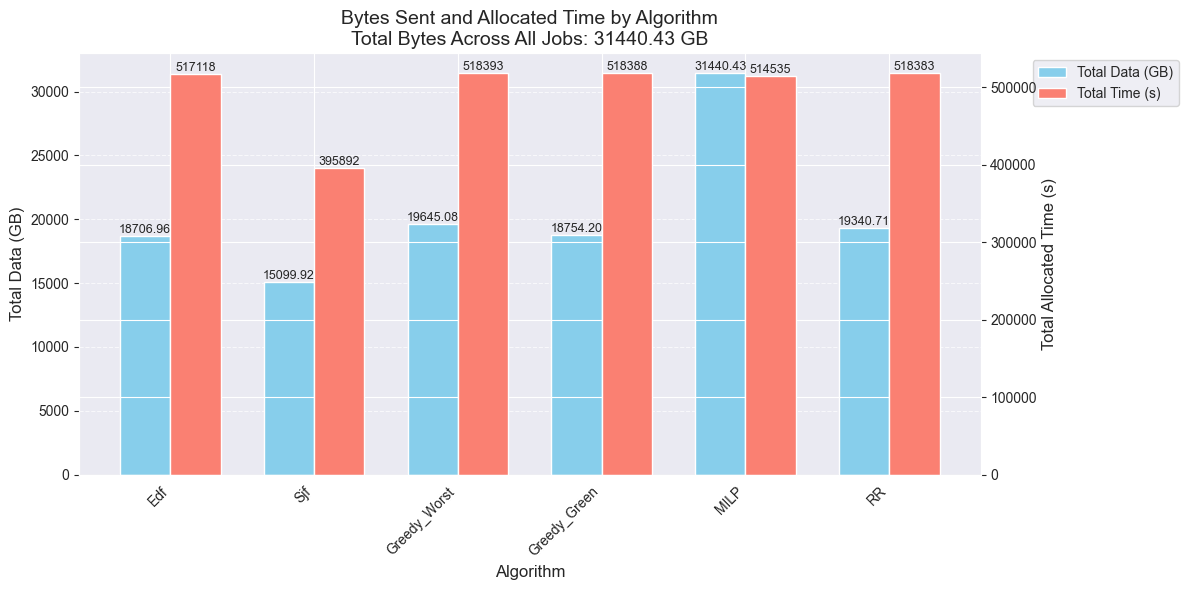

In [94]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming the schedules dictionary is already defined as per the previous code
algo_totals = {}
times_used = {}

# Calculate the total bytes and time for each algorithm
for algo, df in schedules.items():
    bytes_in_algo = 0
    for key, row in df.iterrows():
        bytes_sent = ((row['throughput']/8) * row['allocated_time'])/1e9  # Convert to GB
        algo_totals[algo] = algo_totals.get(algo, 0) + bytes_sent
        times_used[algo] = times_used.get(algo, 0) + row['allocated_time']

# Calculate total bytes across all jobs
total_bytes = 0
for job in job_data:
    total_bytes += job['bytes']

print(total_bytes)

total_bytes = total_bytes / 1e9

algos = list(algo_totals.keys())
bytes_values = list(algo_totals.values())
time_values = list(times_used.values())

# Create figure and primary axis (for bytes)
fig, ax1 = plt.subplots(figsize=(12, 6))
x = np.arange(len(algos))  # Algo positions
width = 0.35  # Bar width

# Plot bytes (left axis)
bars_bytes = ax1.bar(x - width/2, bytes_values, width, color='skyblue', label='Total Data (GB)')
ax1.set_xlabel("Algorithm", fontsize=12)
ax1.set_ylabel("Total Data (GB)", fontsize=12)
ax1.set_title(f"Bytes Sent and Allocated Time by Algorithm\nTotal Bytes Across All Jobs: {total_bytes:.2f} GB", fontsize=14)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels for bytes
for bar in bars_bytes:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2., height,
             f"{height:.2f}",
             ha='center', va='bottom', fontsize=9)

# Create secondary axis (for time)
ax2 = ax1.twinx()
bars_time = ax2.bar(x + width/2, time_values, width, color='salmon', label='Total Time (s)')
ax2.set_ylabel("Total Allocated Time (s)", fontsize=12)

# Add value labels for time
for bar in bars_time:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2., height,
             f"{height:.0f}",
             ha='center', va='bottom', fontsize=9)

ax1.set_xticks(x)
ax1.set_xticklabels(algos, rotation=45, ha='right')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.savefig(f"{graphs_output}/algo_comparison.pdf", dpi=800, format="pdf")
plt.show()


Edf      total emissions: 47,976.26 gCO2
Sjf      total emissions: 35,296.44 gCO2
Greedy_Worst total emissions: 49,396.99 gCO2
Greedy_Green total emissions: 61,422.45 gCO2
MILP     total emissions: 7,170.84 gCO2
RR       total emissions: 50,422.36 gCO2


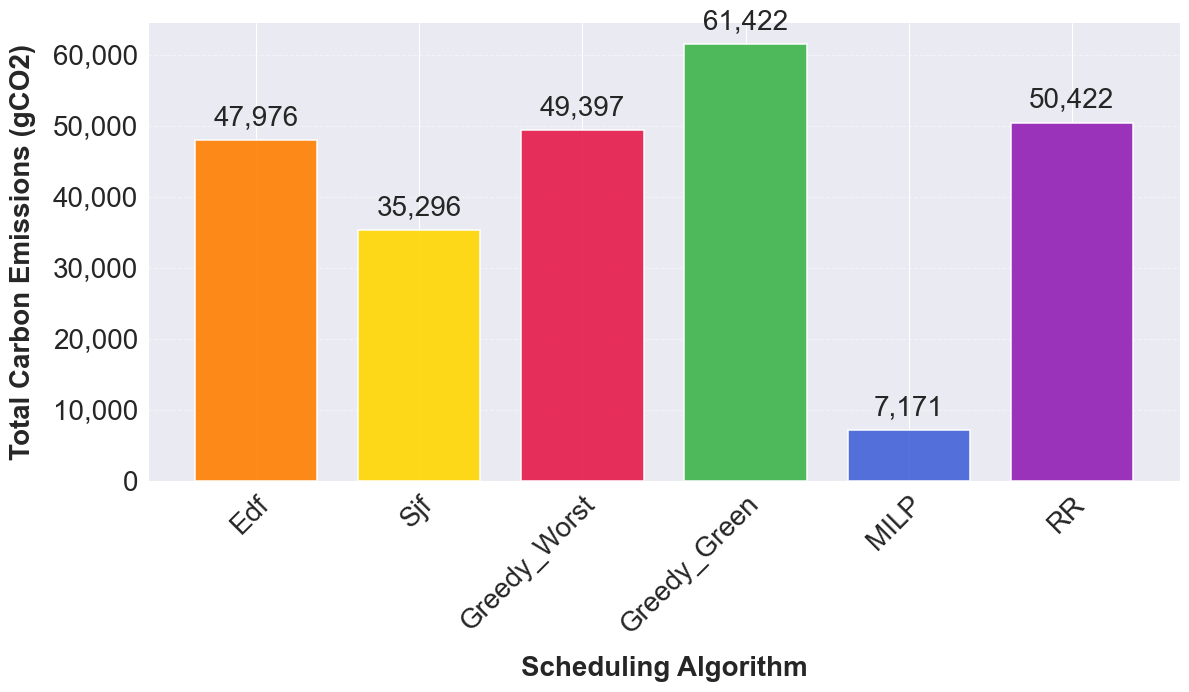

In [87]:
def total_emissions_schedule(schedule_df, schedule_name):
    """Calculate and print total carbon emissions for a schedule"""
    total = schedule_df['carbon_emissions'].sum()
    print(f"{schedule_name:8} total emissions: {total:,.2f} gCO2")
    return total


def plot_algorithm_emissions_comparison():
    """
    Compare carbon emissions across scheduling algorithms with enhanced visualization

    Args:
        save_path: Path to save the output figure
    """
    # Calculate totals
    algorithm_names = []
    emission_totals = []

    for algo_name, df in schedules.items():
        if algo_name in colors:  # Only process if we have a color defined
            total = total_emissions_schedule(df, algo_name)
            algorithm_names.append(algo_name)
            emission_totals.append(total)

    # Create figure with professional styling
    plt.figure(figsize=(12, 7))
    ax = plt.gca()

    # Create bars with consistent ordering
    bars = ax.bar(algorithm_names, emission_totals,
                  color=[colors[algo] for algo in algorithm_names],
                  width=0.75, edgecolor='white', linewidth=1.2, alpha=0.9)

    # Customize axes and labels
    ax.set_xlabel("Scheduling Algorithm", fontsize=20, labelpad=12, fontweight='bold')
    ax.set_ylabel("Total Carbon Emissions (gCO2)", fontsize=20, labelpad=12, fontweight='bold')
    # ax.set_title("Carbon Efficiency of Scheduling Algorithms",
    #             fontsize=14, pad=20, fontweight='bold')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right', rotation_mode='anchor', fontsize=20)
    plt.yticks(fontsize=20)
    # Format y-axis with thousands separator
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        offset = max(emission_totals) * 0.02  # Dynamic offset based on max value
        ax.text(bar.get_x() + bar.get_width() / 2., height + offset,
                f'{height:,.0f}',
                ha='center', va='bottom',
                fontsize=20)

    # Add horizontal grid lines
    ax.yaxis.grid(True, linestyle='--', alpha=0.4)

    # Clean up chart borders
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    # Adjust layout and save
    plt.tight_layout()
    plt.savefig(f'{graphs_output}algorithm_comparison.pdf', format='pdf', dpi=800, bbox_inches='tight')
    plt.show()


# Example usage
plot_algorithm_emissions_comparison()

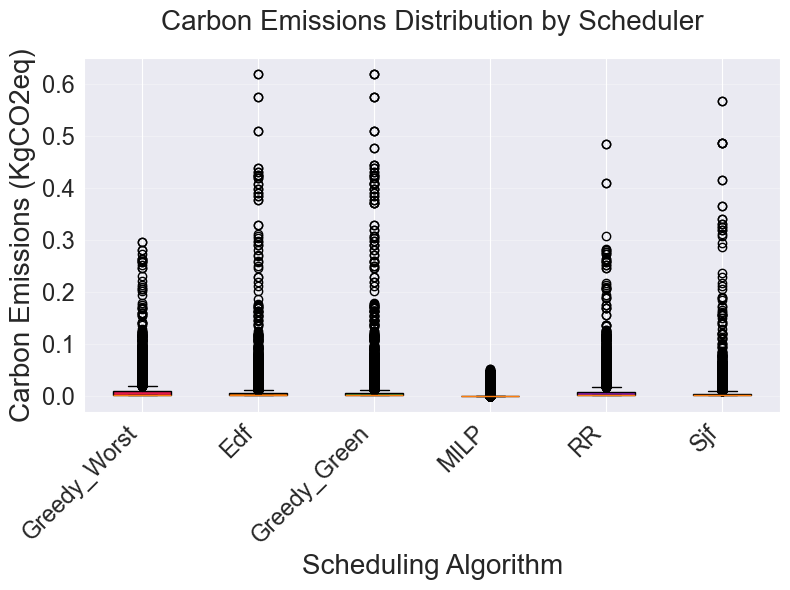

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 2. Prepare Plot Data
# ==================================================
data = []
labels = []
for planner in colors.keys():
    if planner in schedules:
        data.append(schedules[planner]['carbon_emissions'] / 1000)
        labels.append(planner)

# 3. Create Basic Boxplot
# ==================================================
plt.figure(figsize=(8, 6))
ax = plt.gca()

# Create boxplot
boxplot = ax.boxplot(
    data,
    labels=labels,
    patch_artist=True,  # Enable color filling
    showfliers=True
)

# Apply colors
for patch, color in zip(boxplot['boxes'], colors.values()):
    patch.set_facecolor(color)

# Formatting
ax.set_xlabel('Scheduling Algorithm', fontsize=20)
ax.set_ylabel('Carbon Emissions (KgCO2eq)', fontsize=20)
ax.set_title('Carbon Emissions Distribution by Scheduler', fontsize=20, pad=20)
ax.grid(axis='y', alpha=0.3)

# Rotate x-axis labels if needed
plt.xticks(rotation=45, ha='right', fontsize=17)
plt.yticks(fontsize=17)

# 4. Save and Show
# ==================================================
plt.tight_layout()
plt.savefig(f'{graphs_output}boxplot_algos.pdf', format='pdf', dpi=800, bbox_inches='tight')
plt.show()

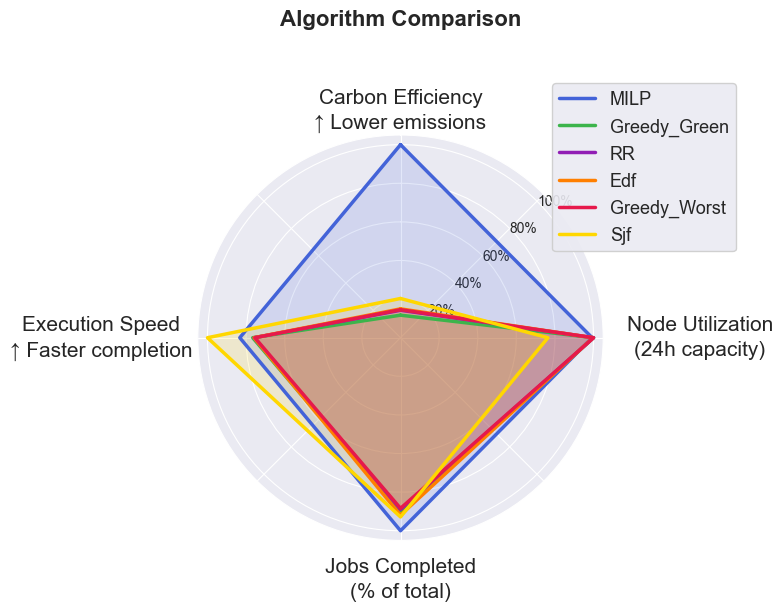

In [89]:
from math import pi


def create_radar_chart(schedule_files, title="Algorithm Comparison"):
    # Load and process data
    metrics = {}
    total_jobs = len(pd.read_csv(next(iter(schedule_files.values())))['job_id'].unique())
    max_hours = 24  # Maximum utilization per node (24 hours)

    for algo, filepath in schedule_files.items():
        df = pd.read_csv(filepath)
        completed_jobs = df['job_id'].nunique()

        # Calculate metrics
        total_allocated_hours = df['allocated_time'].sum() / 3600
        utilization_pct = (total_allocated_hours / max_hours) * 100

        metrics[algo] = {
            '1_Carbon': 1 / (df['carbon_emissions'].sum() + 1e-6),
            '2_Utilization': utilization_pct,
            '3_Completion': (completed_jobs / total_jobs) * 100,
            '4_Speed': 1 / df['allocated_time'].mean()
        }

    # Normalize and cap metrics
    metrics_df = pd.DataFrame(metrics).T
    normalized_df = (metrics_df / metrics_df.max()).clip(upper=1.0)

    # Prepare radar coordinates
    categories = sorted(metrics_df.columns)
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Create figure with optimized layout
    fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'polar': True},
                           constrained_layout=True)

    # Configure polar plot
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    plt.ylim(0, 1.05)  # Slight buffer above 100%

    # Custom label properties
    label_properties = {
        '1_Carbon': {
            'text': 'Carbon Efficiency\n↑ Lower emissions',
            'pad': 1.18,
            'ha': 'center',
            'rotation': 90  # Degrees
        },
        '2_Utilization': {
            'text': 'Node Utilization\n(24h capacity)',
            'pad': 1.55,
            'ha': 'center',
            'rotation': 0
        },
        '3_Completion': {
            'text': 'Jobs Completed\n(% of total)',
            'pad': 1.25,
            'ha': 'center',
            'rotation': 270
        },
        '4_Speed': {
            'text': 'Execution Speed\n↑ Faster completion',
            'pad': 1.55,
            'ha': 'center',
            'rotation': 180
        }
    }

    # Add metric labels with precise positioning
    for angle, category in zip(angles[:-1], categories):
        props = label_properties[category]
        ax.text(
            angle, props['pad'], props['text'],
            ha=props['ha'], va='center',
            fontsize=15,
            linespacing=1.4,
            rotation=angle * 180 / pi - 90 + props['rotation'],
            rotation_mode='anchor'
        )

    # Configure radial grid
    ax.set_rgrids(
        [0.2, 0.4, 0.6, 0.8, 1.0],
        labels=["20%", "40%", "60%", "80%", "100%"],
        angle=45,
        fontsize=10,
        verticalalignment='center'
    )

    ax.set_xticklabels([])
    # Plot each algorithm's data

    for algo in normalized_df.index:
        values = normalized_df.loc[algo].values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, color=colors[algo], linewidth=2.5, label=algo)
        ax.fill(angles, values, color=colors[algo], alpha=0.15)

    # Add title and legend
    plt.title(title, y=1.25, fontsize=16, weight='bold')
    plt.legend(
        loc='upper right',
        bbox_to_anchor=(1.35, 1.15),
        framealpha=0.9,
        fontsize=13
    )

    # Save as high-quality PDF
    plt.savefig(
        f'{graphs_output}/comparison_algos_radar.pdf',
        format="pdf",
        dpi=800,
        bbox_inches='tight',
        transparent=True
    )
    plt.show()


# Example usage
schedule_files = {
    'MILP': f'{schedules_path}milp_binary_schedule.csv',
    'Greedy_Green': f'{schedules_path}green_schedule.csv',
    'RR': f'{schedules_path}rr_schedule.csv',
    'Edf': f'{schedules_path}edf_schedule.csv',
    'Greedy_Worst': f'{schedules_path}worst_schedule.csv',
    'Sjf': f'{schedules_path}sjf_schedule.csv'
}

create_radar_chart(schedule_files)

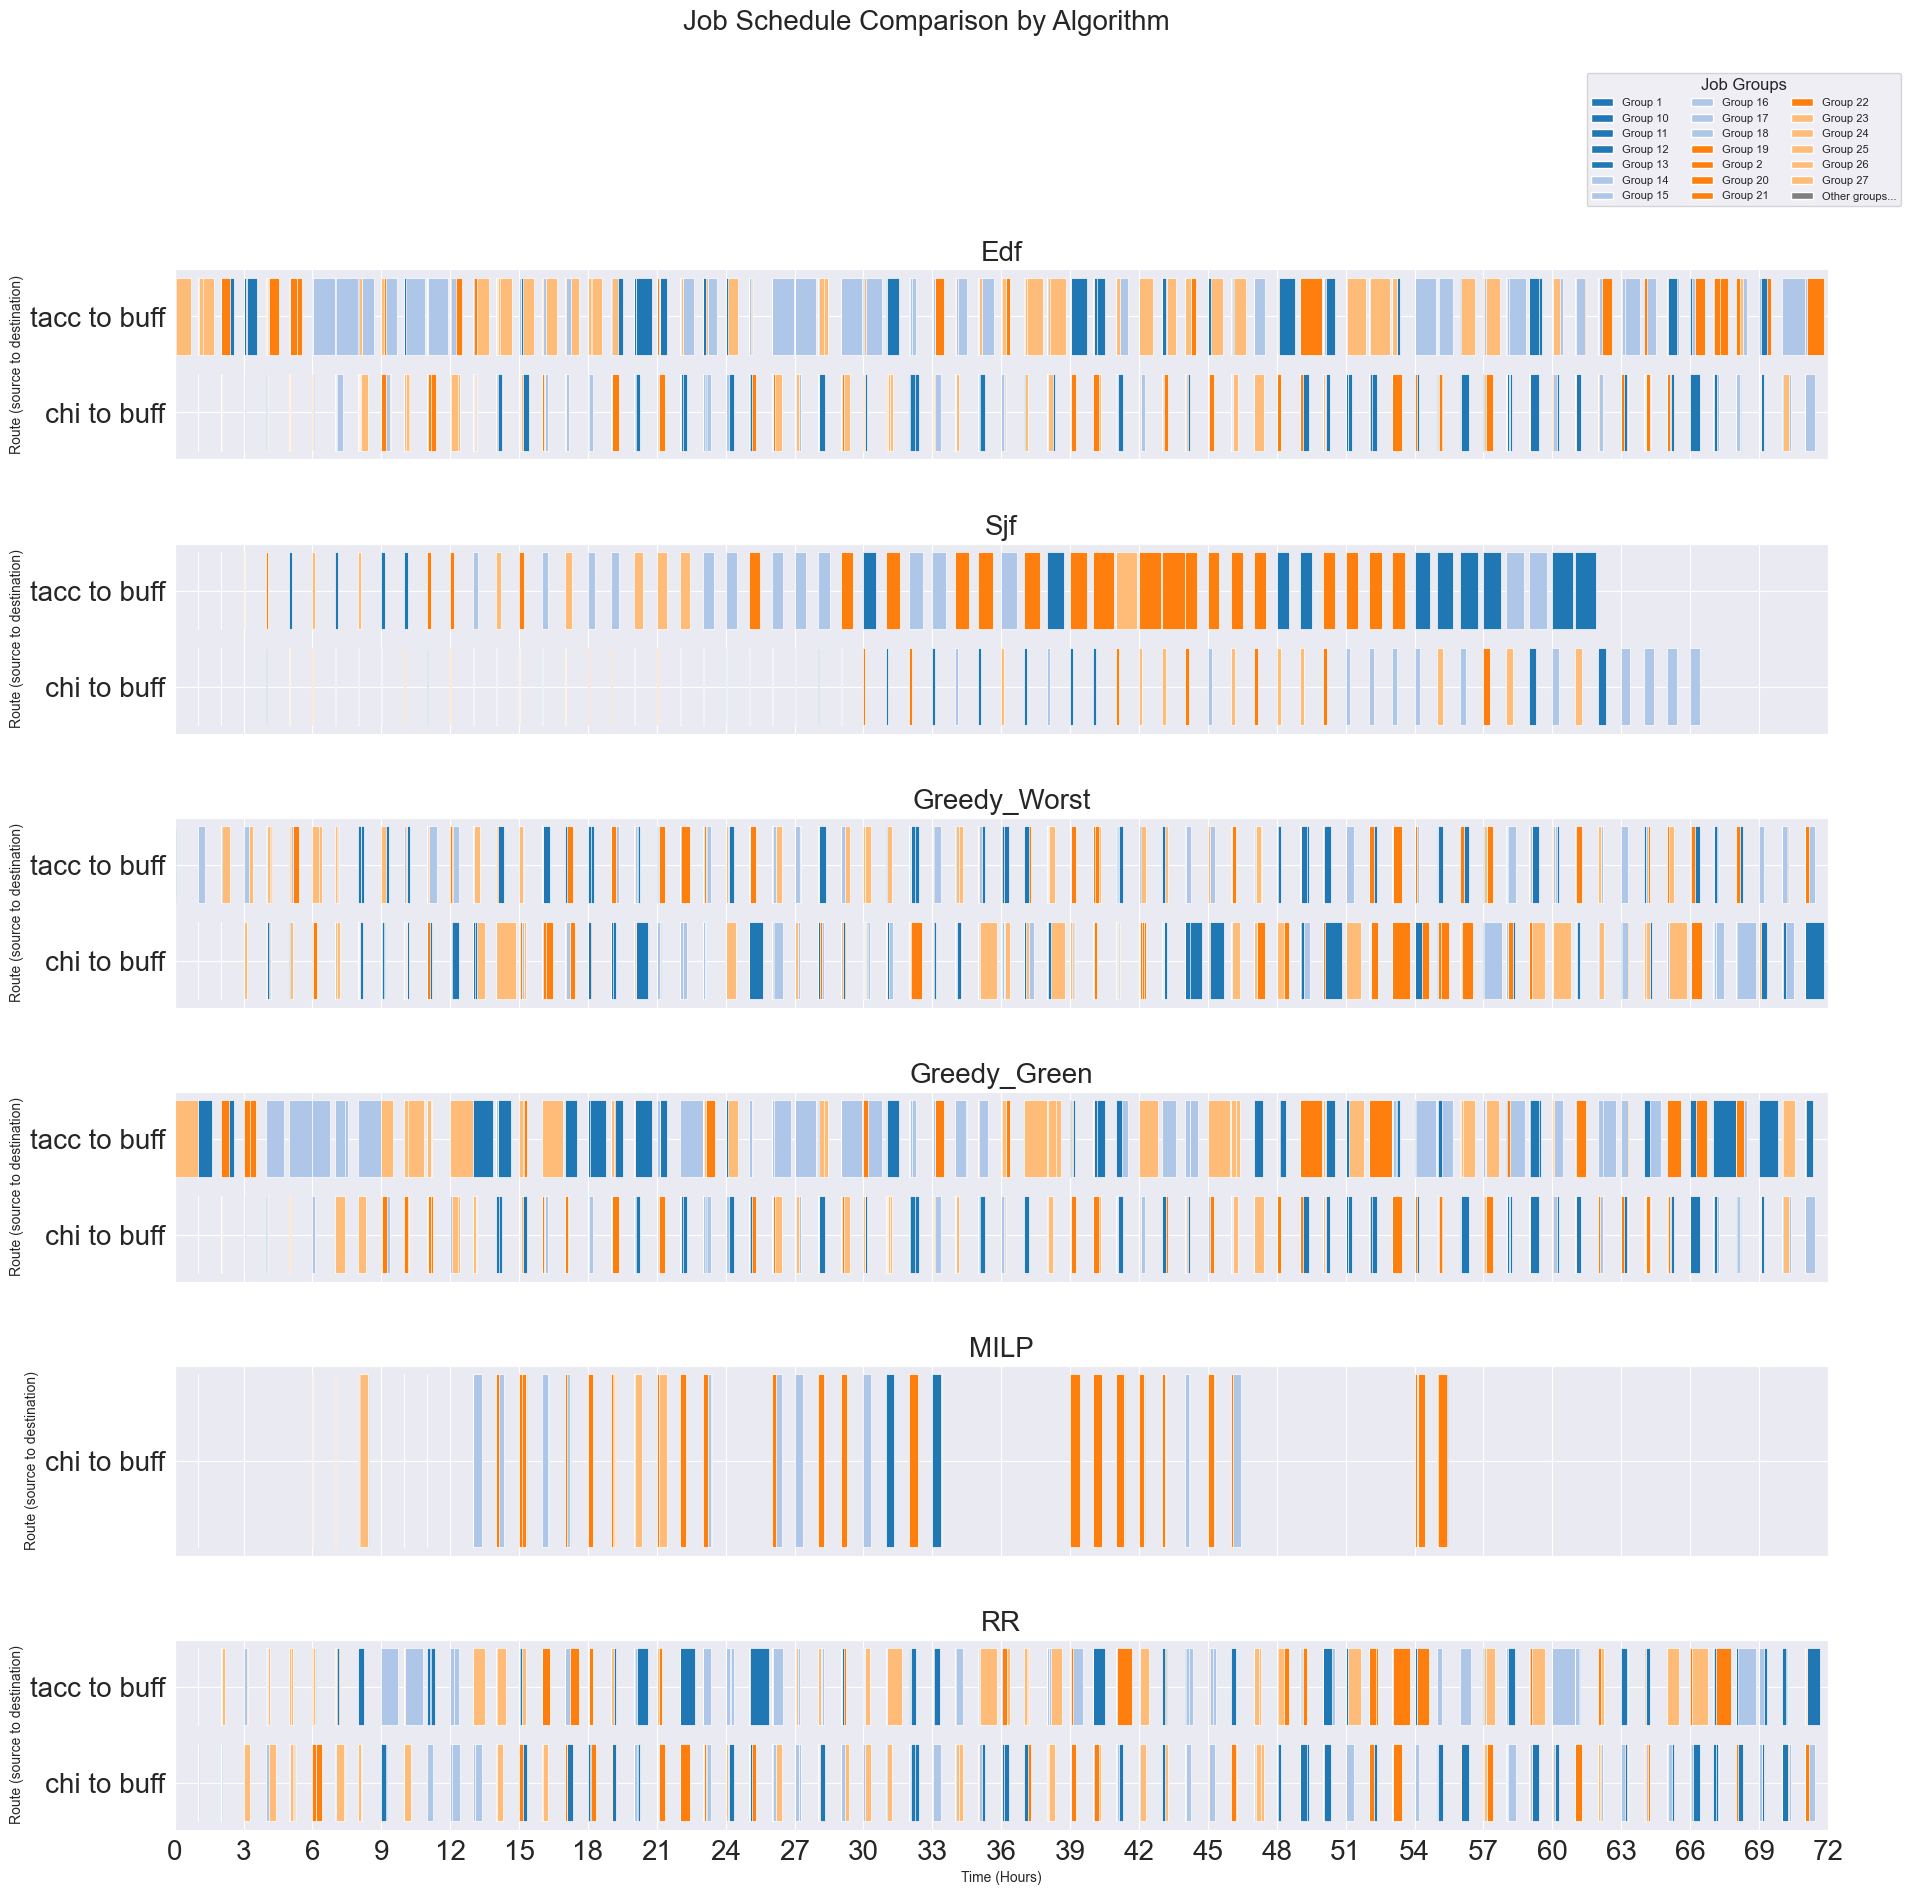

In [107]:
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def create_clean_gantt(schedules, graphs_output='output'):
    """
    Create a clean Gantt chart optimized for a large number of jobs and multiple algorithms.
    Uses only the route (source ➝ dest) for labeling.
    """
    plt.rcParams.update({'font.size': 20})
    # Combine all data and assign algorithm label
    all_data = pd.concat([df.assign(Algorithm=algo) for algo, df in schedules.items()])

    # Create human-readable route labels
    all_data["route"] = all_data["source_node"] + " ➝ " + all_data["destination_node"]

    # Group jobs by job_id prefix for consistent coloring
    all_data["job_group"] = all_data["job_id"].astype(str).str[:2]
    groups = sorted(all_data["job_group"].unique())
    cmap = plt.get_cmap('tab20', len(groups))
    group_colors = {group: cmap(i % 20) for i, group in enumerate(groups)}

    # Setup figure
    n_algorithms = len(schedules)
    fig, axes = plt.subplots(n_algorithms, 1, figsize=(20, 3.2 * n_algorithms), sharex=True)
    fig.suptitle('Job Schedule Comparison by Algorithm', fontsize=20, y=1.02)

    if n_algorithms == 1:
        axes = [axes]

    max_hour = all_data['forecast_id'].max() + (all_data['allocated_time'].max() / 3600)

    for ax, (algo, df) in zip(axes, schedules.items()):
        df = df.copy()
        df["route"] = df["source_node"] + " to " + df["destination_node"]

        # if len(df) > 1000:
        #     df = df.sample(1000, random_state=42)

        for _, row in df.iterrows():
            start_time = row["forecast_id"]
            duration = row["allocated_time"] / 3600  # convert seconds → hours
            route = row["route"]
            job_group = str(row["job_id"])[:2]

            ax.barh(
                y=route,
                width=duration,
                left=start_time,
                height=0.8,
                color=group_colors.get(job_group, "gray"),
                edgecolor="white",
                linewidth=0.5,
            )

        ax.set_title(algo, fontsize=20)
        ax.set_ylabel("Route (source to destination)")
        ax.set_xlim(0, max_hour)
        ax.set_yticks(np.arange(len(df["route"].unique())))
        ax.set_yticklabels(sorted(df["route"].unique()))
        if ax != axes[-1]:
            ax.set_xlabel('')

    axes[-1].set_xlabel("Time (Hours)")
    axes[-1].set_xticks(np.arange(0, int(max_hour) + 1, max(1, int(max_hour) // 20)))

    legend_elements = [
        Patch(facecolor=color, label=f"Group {group}")
        for group, color in list(group_colors.items())[:20]
    ]
    if len(group_colors) > 20:
        legend_elements.append(Patch(facecolor="gray", label="Other groups..."))

    fig.legend(
        handles=legend_elements,
        loc='upper right',
        bbox_to_anchor=(0.99, 0.99),
        title='Job Groups',
        fontsize=8,
        title_fontsize=12,
        ncol=min(3, len(legend_elements))
    )

    plt.tight_layout(pad=3.0, h_pad=2.0)
    plt.savefig(
        f'gantt_chart.pdf',
        format="pdf",
        dpi=800,
        bbox_inches='tight',
        # transparent=True
    )
    plt.show()
    plt.close()

# Usage
create_clean_gantt(schedules)


In [91]:
schedules_space = {
    'Edf': pd.read_csv(f'../schedules/big_job_schedules/space/edf_schedule.csv'),
    'GW': pd.read_csv(f'../schedules/big_job_schedules/space/carbon_aware_max_case.csv'),
    'GG': pd.read_csv(f'../schedules/big_job_schedules/space/carbon_aware_min_case.csv'),
    'MILP': pd.read_csv(f'../schedules/big_job_schedules/space/milp_green.csv'),
    'RR': pd.read_csv(f'../schedules/big_job_schedules/space/round_robin_schedule.csv'),
    'Sjf': pd.read_csv(f'../schedules/big_job_schedules/space/sjf_schedule.csv'),
}

schedules_time = {
    'Edf': pd.read_csv(f'../schedules/big_job_schedules/time/edf_schedule.csv'),
    'GW': pd.read_csv(f'../schedules/big_job_schedules/time/carbon_aware_max_case.csv'),
    'GG': pd.read_csv(f'../schedules/big_job_schedules/time/carbon_aware_min_case.csv'),
    'MILP': pd.read_csv(f'../schedules/big_job_schedules/time/milp_green.csv'),
    'RR': pd.read_csv(f'../schedules/big_job_schedules/time/round_robin_schedule.csv'),
    'Sjf': pd.read_csv(f'../schedules/big_job_schedules/time/sjf_schedule.csv'),
}


# Calculate total emissions for each policy in both space and time
def calculate_total_emissions(schedules_dict):
    return {policy: df['carbon_emissions'].sum()
            for policy, df in schedules_dict.items()}


space_emissions = calculate_total_emissions(schedules_space)
time_emissions = calculate_total_emissions(schedules_time)

# Get the list of policies (assuming all dicts have same keys)
policies = list(schedules_space.keys())

# Set up the plot
plt.figure(figsize=(10, 5))
bar_width = 0.35
x = np.arange(len(policies))

# Create bars
space_bars = plt.bar(x - bar_width / 2, [space_emissions[p] for p in policies],
                     bar_width, label='Space', color='#1f77b4')
time_bars = plt.bar(x + bar_width / 2, [time_emissions[p] for p in policies],
                    bar_width, label='Time', color='#ff7f0e')

# Add labels and title
plt.xlabel('Scheduling Policy', fontsize=15)
plt.ylabel('Total Carbon Emissions', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Comparison of Total Carbon Emissions by Scheduling Policy', fontsize=15)
plt.xticks(x, policies)
plt.legend()


# Add value labels on top of bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2., height,
                 f'{height:,.0f}',
                 ha='center', va='bottom')


add_labels(space_bars)
add_labels(time_bars)

plt.tight_layout()
plt.show()
plt.savefig('graphs/space_time_grouped_bar.pdf', format='pdf', dpi=800)


FileNotFoundError: [Errno 2] No such file or directory: '../schedules/big_job_schedules/space/edf_schedule.csv'

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import json

# Load job metadata

# Convert to DataFrame and rename columns
job_df = pd.DataFrame(job_data).rename(columns={"id": "job_id", "bytes": "job_bytes", "deadline": "deadline"})
job_df["job_gb"] = job_df["job_bytes"] / 1e9  # Convert job size to GB

# Load schedule output
df = schedules['MILP']

# Convert throughput from bits/s to bytes/s and calculate bytes sent
df['throughput_bytes'] = df['throughput'] / 8
df['bytes_sent'] = df['allocated_time'] * df['throughput_bytes']
df['sent_gb'] = df['bytes_sent'] / 1e9  # Convert to GB

# Aggregate by job
sent_gb_per_job = df.groupby("job_id")["sent_gb"].sum().reset_index()

# Merge with job definitions
comparison_df = pd.merge(job_df, sent_gb_per_job, on="job_id", how="left")

# Compute difference
comparison_df["gb_diff"] = comparison_df["job_gb"] - comparison_df["sent_gb"]

# Output results
print(comparison_df[["job_id", "job_gb", "sent_gb", "gb_diff"]])

threshold = 1  # 1 bytes or so
large_error_df = comparison_df[comparison_df["gb_diff"].abs() > threshold]
print(f"Error DF: {large_error_df}")


      job_id    job_gb   sent_gb       gb_diff
0          1  3.765012  3.765012  6.870541e-08
1          2  0.018035  0.018035  2.076310e-10
2          3  0.000173  0.000173  2.816709e-12
3          4  1.919313  1.919313  7.129573e-08
4          5  0.000030  0.000030  2.375070e-13
...      ...       ...       ...           ...
3995    3996  0.910964  0.910964 -2.449717e-09
3996    3997  0.281756  0.281756  2.960522e-09
3997    3998  0.000508  0.000508 -3.101717e-12
3998    3999  1.056264  1.056264  5.673549e-09
3999    4000  0.055604  0.055604 -4.286517e-10

[4000 rows x 4 columns]
Error DF: Empty DataFrame
Columns: [job_bytes, files_count, job_id, deadline, type, job_gb, sent_gb, gb_diff]
Index: []


In [99]:
comp_df = pd.read_csv('../schedules/algorithm_comparison.csv')
print(comp_df)

     Algorithm  Runtime (ms) Jobs Completed Completion % Deadline Met  \
0          edf          0.48      3675/4000        59.5%    3675/3675   
1          sjf          0.45      3714/4000        48.0%    3714/3714   
2        worst          0.40      3536/4000        62.5%    3536/3536   
3        green          0.45      3591/4000        59.6%    3591/3591   
4  milp_binary       7492.25      4000/4000       100.0%    4000/4000   
5           rr          1.03      3559/4000        61.5%    3559/3559   

  On Time %  Carbon (kgCO₂) Avg Throughput     Total Time  Carbon/GB  \
0    100.0%           47.98      0.26 Gbps  259200.00 sec        0.0   
1    100.0%           35.30      0.21 Gbps  241200.00 sec        0.0   
2    100.0%           49.40      0.34 Gbps  259200.00 sec        0.0   
3    100.0%           61.42      0.29 Gbps  259200.00 sec        0.0   
4    100.0%            7.17      0.55 Gbps  133200.00 sec        0.0   
5    100.0%           50.42      0.31 Gbps  259200.00 se